In [2]:
%pylab inline
import biff
from scipy import special
import pygadgetreader
import reading_snapshots

Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [3]:
def xi_transformation(r):
    return (r-1)/(r+1)

def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

def phi_nl(n, l, r, a):
    xi = xi_transformation(r)
    return - special.eval_gegenbauer(n, 2*l + 3/2., xi)*(4*np.pi)**(0.5)*(r/a)**l/((1+r/a)**(2*l+1))  

def rho_nl(n, l, r, a):
    xi = xi_transformation(r)
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)

    return knl/(2*np.pi) * special.eval_gegenbauer(n, 2*l + 3/2., xi)*(4*np.pi)**(0.5)*(r/a)**l/((1+r/a)**(2*l+3))


def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

def snl(n, l, m, m_p, r_p, theta_p, phi_p, a):
    A_nl = Anl(n,l)
    if m==0:
        S_nl = A_nl * np.sum(m_p*phi_nl(n, l, r_p, a)*special.sph_harm(m, l, 0, theta_p)*np.cos(m*phi_p))
        print(np.sum(phi_nl(n, l, r_p, a)), np.sum(special.sph_harm(m, l, 0, theta_p)), A_nl)
    if m!=0:
        S_nl = 2.*A_nl * np.sum(m_p*phi_nl(n, l, r_p, a)*special.sph_harm(m, l, 0, theta_p)*np.cos(m*phi_p))
    return S_nl.real

def var_snl(n, l, m, m_p, r_p, theta_p, phi_p, a):
    """
    Computing the variance of S_nl
    
    
    """
    A_nl = Anl(n,l)
    if m==0:
        var_S_nl = A_nl**2 * np.sum(m_p**2*phi_nl(n, l, r_p, a)**2*special.sph_harm(m, l, 0, theta_p)**2*np.cos(m*phi_p)**2)
        #print(np.sum(phi_nl(n, l, r_p, a)), np.sum(special.sph_harm(m, l, 0, theta_p)), A_nl)
    if m!=0:
        var_S_nl = (2.*A_nl)**2 * np.sum(m_p**2*phi_nl(n, l, r_p, a)**2*special.sph_harm(m, l, 0, theta_p)**2*np.cos(m*phi_p)**2)
    return var_S_nl.real - snl(n, l, m, m_p, r_p, theta_p, phi_p, a)**2

def b_Snlm(n, l, m, m_p, r_p, theta_p, phi_p, a):
    b_nlm = 1/(1 + var_snl(n, l, m, m_p, r_p, theta_p, phi_p, a)/snl(n, l, m, m_p, r_p, theta_p, phi_p, a)**2)
    return b_nlm

In [158]:
MW_post = reading_snapshots.read_MW_snap_com_coordinates('../../MW_anisotropy/code/test_snaps/', 'MWLMC5_100M_new_b1_110', LMC=True,
                                                                 N_halo_part=100000000, pot=True)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Potential
Returning DM    Potential
Loading MW particles and LMC particles


In [32]:
M_dm = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/MWLMC5_100M_new_b1_110', 'mass', 'dm')

Returning DM    Mass


In [33]:
M_dm[0]

1.5772125e-06

In [ ]:
MW_iso = reading_snapshots.read_MW_snap_com_coordinates('../../MW_anisotropy/code/test_snaps/', 'MW_post', LMC=True,
                                                                 N_halo_part=40000000, pot=True)

In [159]:
r_mwlmc5 = (MW_post[0][:,0]**2 + MW_post[0][:,1]**2 + MW_post[0][:,2]**2)**0.5
index_cut = np.where(r_mwlmc5 < 300)[0]

In [160]:
len(index_cut)

77615338

In [161]:
savetxt('MWLMC5_pos_100M_b1.txt', np.array([MW_post[0][index_cut,0], MW_post[0][index_cut,1], MW_post[0][index_cut,2], np.ones(len(index_cut))]).T)

In [36]:
rmw = r_mwlmc5[index_cut] 
theta_mw = np.arccos(MW_post[0][index_cut,2]/rmw)
phi_mw = np.arctan2(MW_post[0][index_cut,1], MW_post[0][index_cut,0])

In [48]:
%time snl(0, 0, 0, np.ones(len(index_cut)), rmw, theta_mw, phi_mw, 40.8)

-45906880.083752126 (8815737.003260335+0j) -2.9999999999999996
CPU times: user 7.09 s, sys: 237 ms, total: 7.33 s
Wall time: 7.33 s


(38850275.334643304, -45906880.083752126, (8815737.003260335+0j))

In [84]:
%time S_mwlmc, T_mwlmc = biff.compute_coeffs_discrete(np.double(MW_post[0][index_cut]), np.double(np.ones(len(index_cut))), 5, 5, skip_m=False, r_s=40.85)

CPU times: user 21min 15s, sys: 1.35 s, total: 21min 16s
Wall time: 21min 17s


In [110]:
S_mwlmc[:][0][0]

array([38873482.89261942,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ])

In [52]:
%time var_snl(0, 0, 0, np.ones(len(index_cut)), rmw, theta_mw, phi_mw, 40.8)

-45906880.083752126 (8815737.003260335+0j) -2.9999999999999996
CPU times: user 7.45 s, sys: 271 ms, total: 7.72 s
Wall time: 7.73 s


-1509343833867636.2

In [56]:
%time b_Snlm(0, 0, 0, np.ones(len(index_cut)), rmw, theta_mw, phi_mw, 40.8)

-45906880.083752126 (8815737.003260335+0j) -2.9999999999999996
-45906880.083752126 (8815737.003260335+0j) -2.9999999999999996
CPU times: user 12.6 s, sys: 371 ms, total: 13 s
Wall time: 13 s


25277926.022728357

In [17]:
coeff_c = np.loadtxt('../data/MWLMC5_coeff_20_20_100M_b1.txt')
S_cov = np.loadtxt('../data/MWLMC5_cov_20_20_100M_b1.txt')

In [18]:
S = coeff_c[:,0]
T = coeff_c[:,1]


In [19]:
S_matrix = np.zeros((21, 21, 21))
T_matrix = np.zeros((21, 21, 21))
S_cov_matrix = np.zeros((21, 21, 21))

In [20]:
S_matrix_1 = np.zeros((21, 21, 21))
T_matrix_1 = np.zeros((21, 21, 21))

In [21]:
S_matrix_1[0,0,0] = S_matrix[0,0,0]
T_matrix_1[0,0,0] = S_matrix[0,0,0]

In [22]:
counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            S_matrix[n][l][m] = S[counter]
            S_cov_matrix[n][l][m] = S_cov[counter]
            T_matrix[n][l][m] = T[counter]
            counter +=1

In [12]:
y_grid_2 = np.arange(-300, 300, 5)
z_grid_2 = np.arange(-300, 300, 5)
y_grid_2, z_grid_2 = meshgrid(y_grid_2, z_grid_2)
rho_biff = biff.density(np.ascontiguousarray(np.array([np.zeros(len(y_grid_2.flatten())), y_grid_2.flatten(), z_grid_2.flatten()]).T), S_matrix, T_matrix, r_s=40.85)

In [22]:
rho_biff_1 = biff.density(np.ascontiguousarray(np.array([np.zeros(len(y_grid_2.flatten())), y_grid_2.flatten(), z_grid_2.flatten()]).T), S_matrix_1, T_matrix_1, r_s=40.85)

In [23]:
rho_matrix = reshape(rho_biff, (120, 120))
rho_matrix_1 = reshape(rho_biff_1, (120, 120))


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


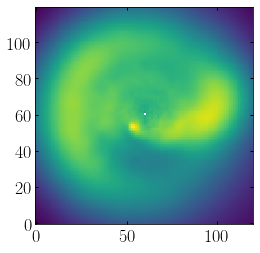

In [33]:
#imshow(((rho_matrix)/rho_matrix_1-1), origin='lower')
imshow((rho_matrix/rho_matrix_1 -1), origin='lower', cmap='viridis')

In [177]:
M_total = np.sum(M_dm)
M_total

175.71605

In [179]:
b_nlm = np.zeros((21, 21, 21))
for i in range(21):
    for j in range(21):
        for k in range(0, j+1):
            b_nlm[i][j][k] = 1 / (1-M_total*(S_cov_matrix[i][j][k] - S_matrix[i][j][k]**2)/(S_matrix[i][j][k]**2))

In [180]:
1 / (1-(M_dm[0]*(S_cov_matrix[0][20][0] - S_matrix[0][20][0]**2)/(S_matrix[0][20][0]**2)))

0.99999869896938676

In [181]:
b_nlm[3][0][0]

0.0056588071562847049

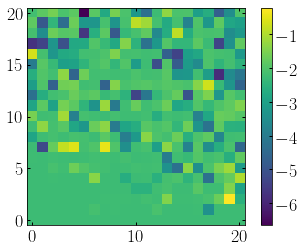

In [183]:
imshow(np.log10(np.abs(b_nlm[:,:,0].T)), origin='lower')
colorbar()

In [29]:
(S_cov_matrix[0][0][0] - S_matrix[0][0][0]**2)/S_matrix[0][0][0]**2

-0.99999998399419565

In [31]:
1 /(1 + -0.99)

99.99999999999991

In [ ]:
def mise_error():
    for i in n:
        for j in l:
            for k in m:
                b_Snlm(i, j, k, ...) * var_snl(i, j, k ....) + (b_Snlm(i, j, k, ...) - 1)**2 * snl(i, j, k)**2